<a href="https://colab.research.google.com/github/SoundharavalliKT/Pro_1/blob/main/Autoencoder_cifar_10_51_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''Colorization autoencoder
The autoencoder is trained with grayscale images as input
and colored images as output.
Colorization autoencoder can be treated like the opposite
of denoising autoencoder. Instead of removing noise, colorization
adds noise (color) to the grayscale image.
Grayscale Images --> Colorization --> Color Images
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()

In [ ]:
# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

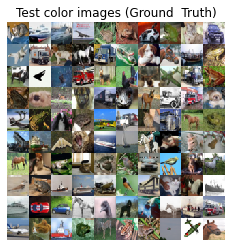

In [ ]:
# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

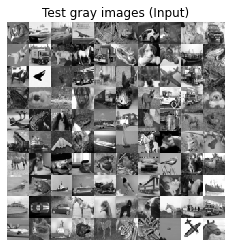

In [ ]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [ ]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [ ]:
# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [ ]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [ ]:
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        640       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

In [ ]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [ ]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              1052672   
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 256)        590080    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 64)       7379

In [ ]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [ ]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam',metrics=['acc'])

In [ ]:
# called every epoch
callbacks = [lr_reducer, checkpoint]

In [ ]:
# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0156 - acc: 0.4749
Epoch 00001: val_loss improved from inf to 0.01104, saving model to /content/saved_models/colorized_ae_model.001.h5
1563/1563 [==============================] - 48s 29ms/step - loss: 0.0156 - acc: 0.4749 - val_loss: 0.0110 - val_acc: 0.4552 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0102 - acc: 0.4988
Epoch 00002: val_loss improved from 0.01104 to 0.00958, saving model to /content/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 40s 26ms/step - loss: 0.0102 - acc: 0.4988 - val_loss: 0.0096 - val_acc: 0.5073 - lr: 0.0010
Epoch 3/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.5055
Epoch 00003: val_loss improved from 0.00958 to 0.00896, saving model to /content/saved_models/colorized_ae_model.003.h5
1563/1563 [==============================] - 41s 26ms/step - loss: 0.0093 - acc: 0.5055 -

In [ ]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

In [ ]:
x_decoded

array([[[[0.37177116, 0.4544018 , 0.5266744 ],
         [0.36885384, 0.4514463 , 0.52248824],
         [0.37795532, 0.44633898, 0.5027126 ],
         ...,
         [0.36764148, 0.37444288, 0.36272112],
         [0.34313035, 0.35018632, 0.3269637 ],
         [0.33404642, 0.34518036, 0.3293296 ]],

        [[0.38357937, 0.45924532, 0.52265424],
         [0.38038248, 0.45334098, 0.52219564],
         [0.388205  , 0.45217773, 0.507781  ],
         ...,
         [0.38167188, 0.3788376 , 0.36596113],
         [0.36119363, 0.35714278, 0.33306253],
         [0.33753204, 0.3400385 , 0.32830757]],

        [[0.38209316, 0.45965272, 0.5250869 ],
         [0.38851574, 0.45717296, 0.5120766 ],
         [0.39892694, 0.45902574, 0.49896234],
         ...,
         [0.40216613, 0.3999422 , 0.38243002],
         [0.37014768, 0.36702424, 0.34302664],
         [0.34550902, 0.3462022 , 0.3272352 ]],

        ...,

        [[0.3517807 , 0.37705758, 0.35681513],
         [0.3263964 , 0.34960702, 0.32244217]

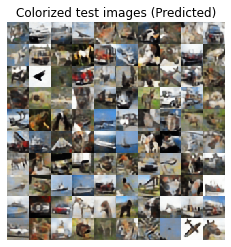

In [ ]:
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()